| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

In [1]:
library("dplyr", warn.conflicts = FALSE)
library("ggplot2", warn.conflicts = FALSE)
library("geosphere", warn.conflicts = FALSE)
library("spatstat", warn.conflicts = FALSE)
library("gridExtra", warn.conflicts = FALSE)

Loading required package: spatstat.data

Loading required package: spatstat.geom

spatstat.geom 3.2-9


Attaching package: ‘spatstat.geom’


The following object is masked from ‘package:geosphere’:

    perimeter


Loading required package: spatstat.random

spatstat.random 3.2-3

Loading required package: spatstat.explore

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


spatstat.explore 3.2-7

Loading required package: spatstat.model

Loading required package: rpart

spatstat.model 3.2-11

Loading required package: spatstat.linnet

spatstat.linnet 3.1-5


spatstat 3.0-8 
For an introduction to spatstat, type ‘beginner’ 




# Exercise 1: Bayesian Inference for Poisson model

The number of particles emitted by a radioactive source during a fixed interval of time ($\Delta t = 10 s$) follows a Poisson distribution on the parameter $\mu$. The number of particles observed during consecutive time intervals is: 4, 1, 3, 1, 5 and 3.

(a) Assuming a positive uniform prior distribution for the parameter $\mu$:
- determine and draw the posterior distribution for $\mu$, given the data;
- evaluate mean, median and variance, both analytically and numerically in R.

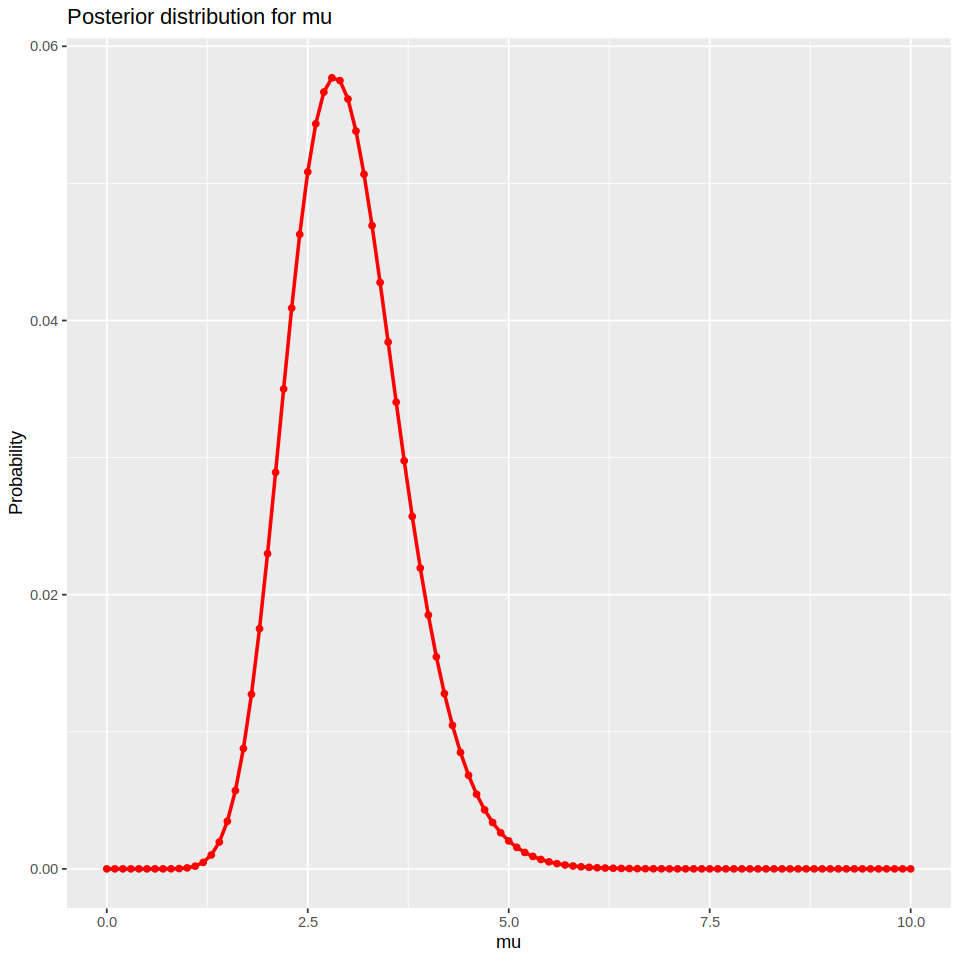

In [37]:
delta_t <- 10
num_occ <- c(4, 1, 3, 1, 5, 3)

post_un <- function(x, mu, limits) {
  uniform <- 1 / (limits[2] - limits[1])
  n <- length(x)
  exp <- sum(x)

  normalization <- sum(uniform * exp(-mu * n) * (mu) **(exp))

  return(uniform * exp(- mu * n) * (mu)**(exp) / normalization)
}

mu <- seq(0, 10, 0.1)
post_values <- post_un(num_occ, mu, c(min(mu), max(mu)))

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(mu, post_values), aes(x = mu, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability")

In [38]:
mean_analytical <- sum(mu * post_values)
variance_analytical <- sum((mu**2) * post_values) - mean_analytical**2

cdf_post <- function(x, post_val) {
  result <- 0
  for (i in 1:x){
    result <- result + post_val[i]
  }

  return(result)
}

median_index <- round(uniroot(function(x) cdf_post(x, post_values) - 0.5,
                              lower = 1, upper = length(mu))$root)
median_analytical <- mu[median_index]

mean_numerical <- weighted.mean(mu, post_values)
median_numerical <- weighted.median(mu, post_values)
variance_numerical <- weighted.var(mu, post_values)

cat("Analytical Mean:", mean_analytical, "\n")
cat("Analytical Median:", median_analytical, "\n")
cat("Analytical Variance:", variance_analytical, "\n \n")

cat("Numerical Mean:", mean_numerical, "\n")
cat("Numerical Median:", median_numerical, "\n")
cat("Numerical Variance:", variance_numerical, "\n")


Analytical Mean: 3 
Analytical Median: 2.9 
Analytical Variance: 0.5 
 
Numerical Mean: 3 
Numerical Median: 2.85 
Numerical Variance: 0.5212406 


(b) assuming a Gamma prior such that the expected value is $\mu = 3$ with a standard deviation $\sigma = 1$:
- determine and draw the posterior distribution for $\mu$, given the data:
- evaluate mean, median and variance, both analytically and numerically in R.

First of all we need to compute the parameters of the Gamma distribution with $\mu = 3$ and $\sigma = 1$:

$
\begin{cases} 
\mu = \alpha \beta \\
\sigma ^ 2 = \alpha \beta^2
\end{cases}
$

From this we get: $\alpha = 9$ and $\beta = 1/3$.

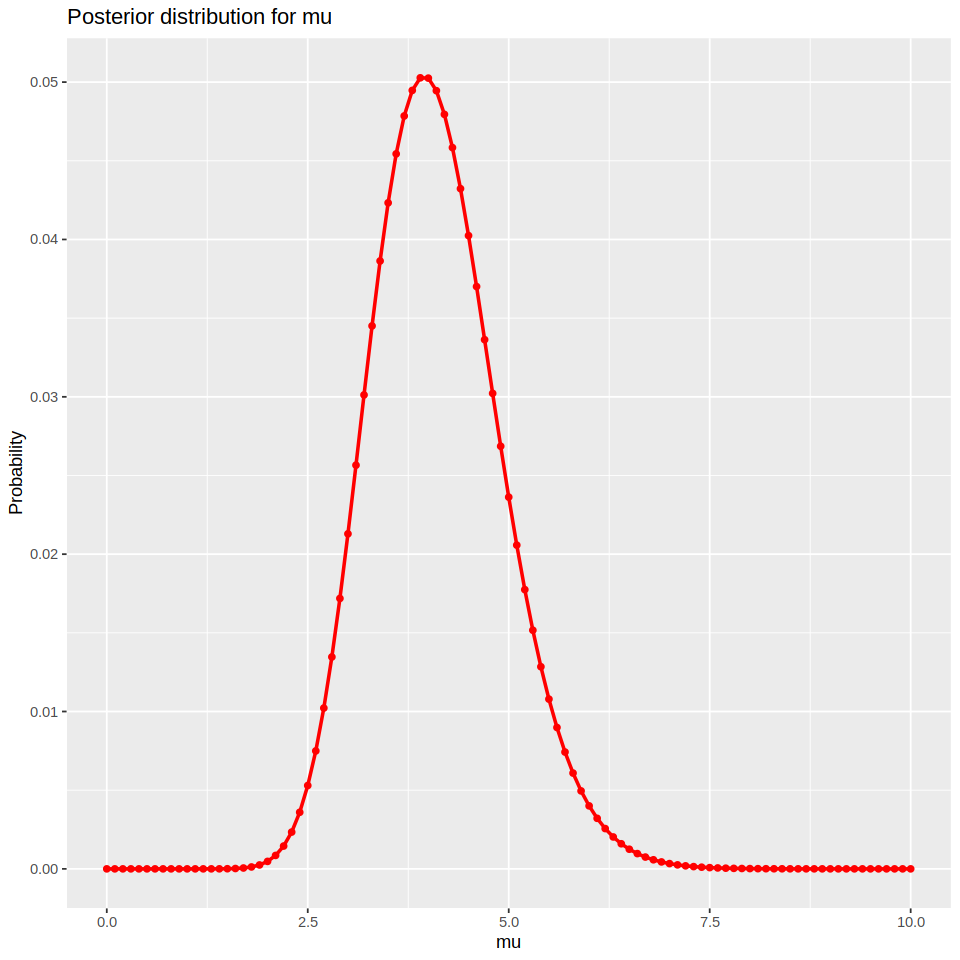

In [39]:
post_gam <- function(x, mu, alpha, beta) {
  gamma <- dgamma(mu, shape = alpha, rate = beta)
  n <- length(x)
  exp <- sum(x)

  normalization <- sum(gamma * exp(-mu * n) * (mu) **(exp))

  return(gamma * exp(- mu * n) * (mu)**(exp) / normalization)
}

mu <- seq(0, 10, 0.1)
alpha <- 9
beta <- 1 / 3
post_values_gamma <- post_gam(num_occ, mu, alpha, beta)

ggplot(data = data.frame(mu, post_values_gamma),
       aes(x = mu, y = post_values_gamma)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability")

In [40]:
mean_analytical <- sum(mu * post_values_gamma)
variance_analytical <- sum((mu**2) * post_values_gamma) - mean_analytical**2

median_index <- round(uniroot(function(x) cdf_post(x, post_values_gamma) - 0.5,
                              lower = 1, upper = length(mu))$root)
median_analytical <- mu[median_index]

mean_numerical <- weighted.mean(mu, post_values_gamma)
median_numerical <- weighted.median(mu, post_values_gamma)
variance_numerical <- weighted.var(mu, post_values_gamma)

cat("Analytical Mean:", mean_analytical, "\n")
cat("Analytical Median:", median_analytical, "\n")
cat("Analytical Variance:", variance_analytical, "\n \n")

cat("Numerical Mean:", mean_numerical, "\n")
cat("Numerical Median:", median_numerical, "\n")
cat("Numerical Variance:", variance_numerical, "\n")

Analytical Mean: 4.105263 
Analytical Median: 4.1 
Analytical Variance: 0.6481983 
 
Numerical Mean: 4.105263 
Numerical Median: 4.05 
Numerical Variance: 0.6720938 


(c) evaluate a 95% credibility interval for the results obtained with different priors. Compare the result with that obtained using a normal approximation for the posterior distribution, with the same mean and standard deviation.

In [41]:
c_int <- function(val, int, param) {
  low <- 0
  up <- 0
  a <- 1
  b <- 1

  limits <- c((1 - int) / 2, (1 + int) / 2)

  while (low < limits[1]) {
    low <- low + val[a]
    a <- a + 1
  }

  while (up < limits[2]) {
    up <- up + val[b]
    b <- b + 1
  }

  return(c(param[a], param[b]))
}

norm_values <- dnorm(mu, mean = 3, sd = 1)
const <- sum(norm_values)
norm_values <- norm_values / const

un_c_int <- c_int(post_values, 0.95, mu)
gamma_c_int <- c_int(post_values_gamma, 0.95, mu)
norm_c_int <- c_int(norm_values, 0.95, mu)

cat("95% Credibility Interval for Uniform prior: (", un_c_int[1], ",", un_c_int[2], ")\n") # nolinter
cat("95% Credibility Interval for Gamma prior: (", gamma_c_int[1], ",", gamma_c_int[2], ")\n") # nolinter
cat("95% Credibility Interval for Normal posterior: (", norm_c_int[1], ",", norm_c_int[2], ")\n") # nolinter

95% Credibility Interval for Uniform prior: ( 1.9 , 4.6 )
95% Credibility Interval for Gamma prior: ( 2.8 , 5.9 )
95% Credibility Interval for Normal posterior: ( 1.2 , 5.1 )


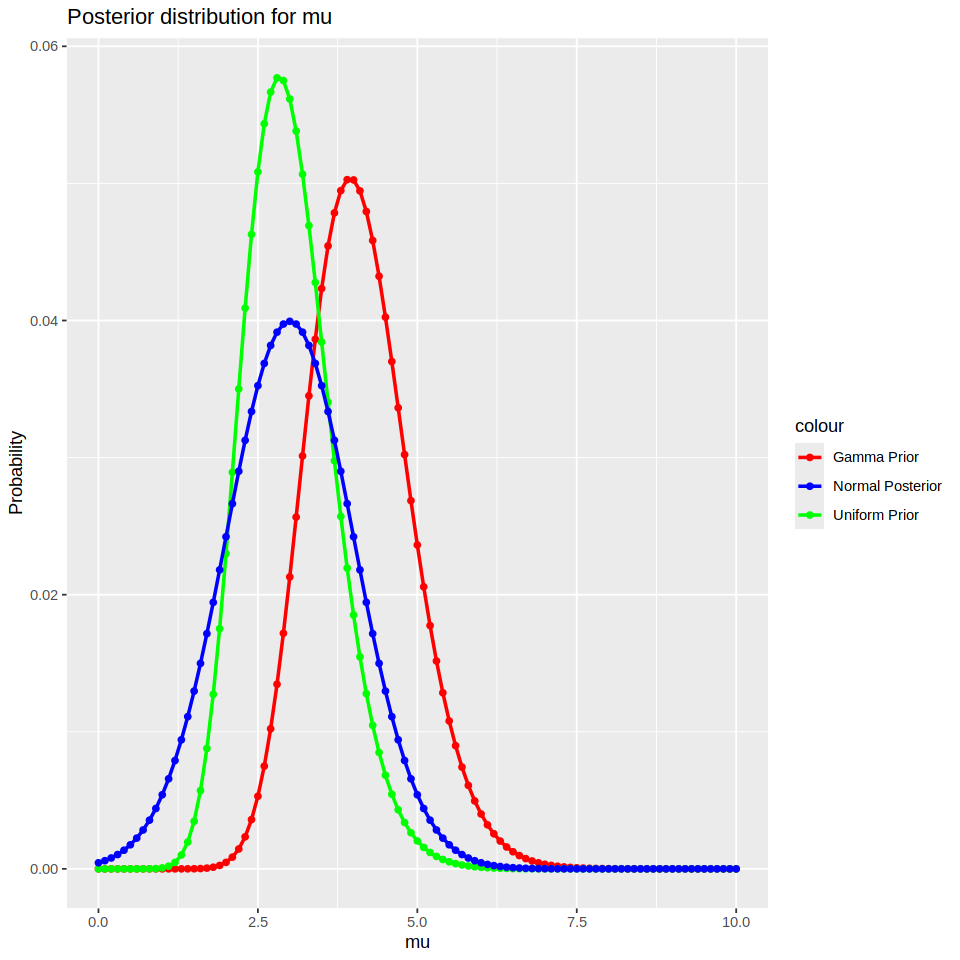

In [42]:
ggplot(data = data.frame(mu, post_values_gamma, post_values, norm_values),
       aes(x = mu)) +
  geom_point(aes(y = post_values_gamma, color = "Gamma Prior"), size = 1.5) +
  geom_line(aes(y = post_values_gamma, color = "Gamma Prior"), linewidth = 1) +
  geom_point(aes(y = post_values, color = "Uniform Prior"), size = 1.5) +
  geom_line(aes(y = post_values, color = "Uniform Prior"), linewidth = 1) +
  geom_point(aes(y = norm_values, color = "Normal Posterior"), size = 1.5) +
  geom_line(aes(y = norm_values, color = "Normal Posterior"), linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability") +
  scale_color_manual(values = c("red", "blue", "green"),
                     labels = c("Gamma Prior", "Normal Posterior",
                                "Uniform Prior"))

# Exercise 2: Efficiency using Bayesian approach

A researcher A wants to evaluate the efficiency of detector 2 (Det2). For this purpose, he sets up the apparatus shown in the figure 1, where Det2 is sandwiched between Det1 and Det3. Let $n$ be the number of signals recorded simultaneously by Det1 and Det3, and
$r$ be those also recorded by Det2, researcher A obtains $n = 500$ and $r = 312$. Assuming a binomial model where $n$ is the number of trials and $r$ is the number of success out of $n$ trials:

(a) Evaluate the mean and the variance using a Bayesian approach under the hypothesis of:
- uniform prior ∼ U(0,1)
- Jeffrey’s prior ∼ Beta(1/2,1/2)

In [43]:
post_un_bern <- function(r, n, limits, p) {
  uniform <- 1 / (limits[2] - limits[1])
  normalization <- sum(uniform * dbinom(r, n, p))

  return(uniform * dbinom(r, n, p) / normalization)
}

post_beta_bern <- function(r, n, params, p) {
  beta <- dbeta(p, params[1], params[2])
  normalization <- sum(beta * dbinom(r, n, p))

  return(beta * dbinom(r, n, p) / normalization)
}

r <- 312
n <- 500
a <- 1 / 2
b <- 1 / 2
p <- seq(0.01, 1 - 0.01, 0.01)

bern_un_values <- post_un_bern(r, n, c(min(p), max(p)), p)
bern_beta_values <- post_beta_bern(r, n, c(a, b), p)

cat("Mean with Uniform prior:", weighted.mean(p, bern_un_values), "\n")
cat("Variance with Uniform prior:", weighted.var(p, bern_un_values), "\n")
cat("Mean with Beta prior:", weighted.mean(p, bern_beta_values), "\n")
cat("Variance with Beta prior:", weighted.var(p, bern_beta_values), "\n")

Mean with Uniform prior: 0.623506 
Variance with Uniform prior: 0.0005367422 
Mean with Beta prior: 0.6237525 
Variance with Beta prior: 0.0005376019 


(b) Plot the posterior distributions for both cases

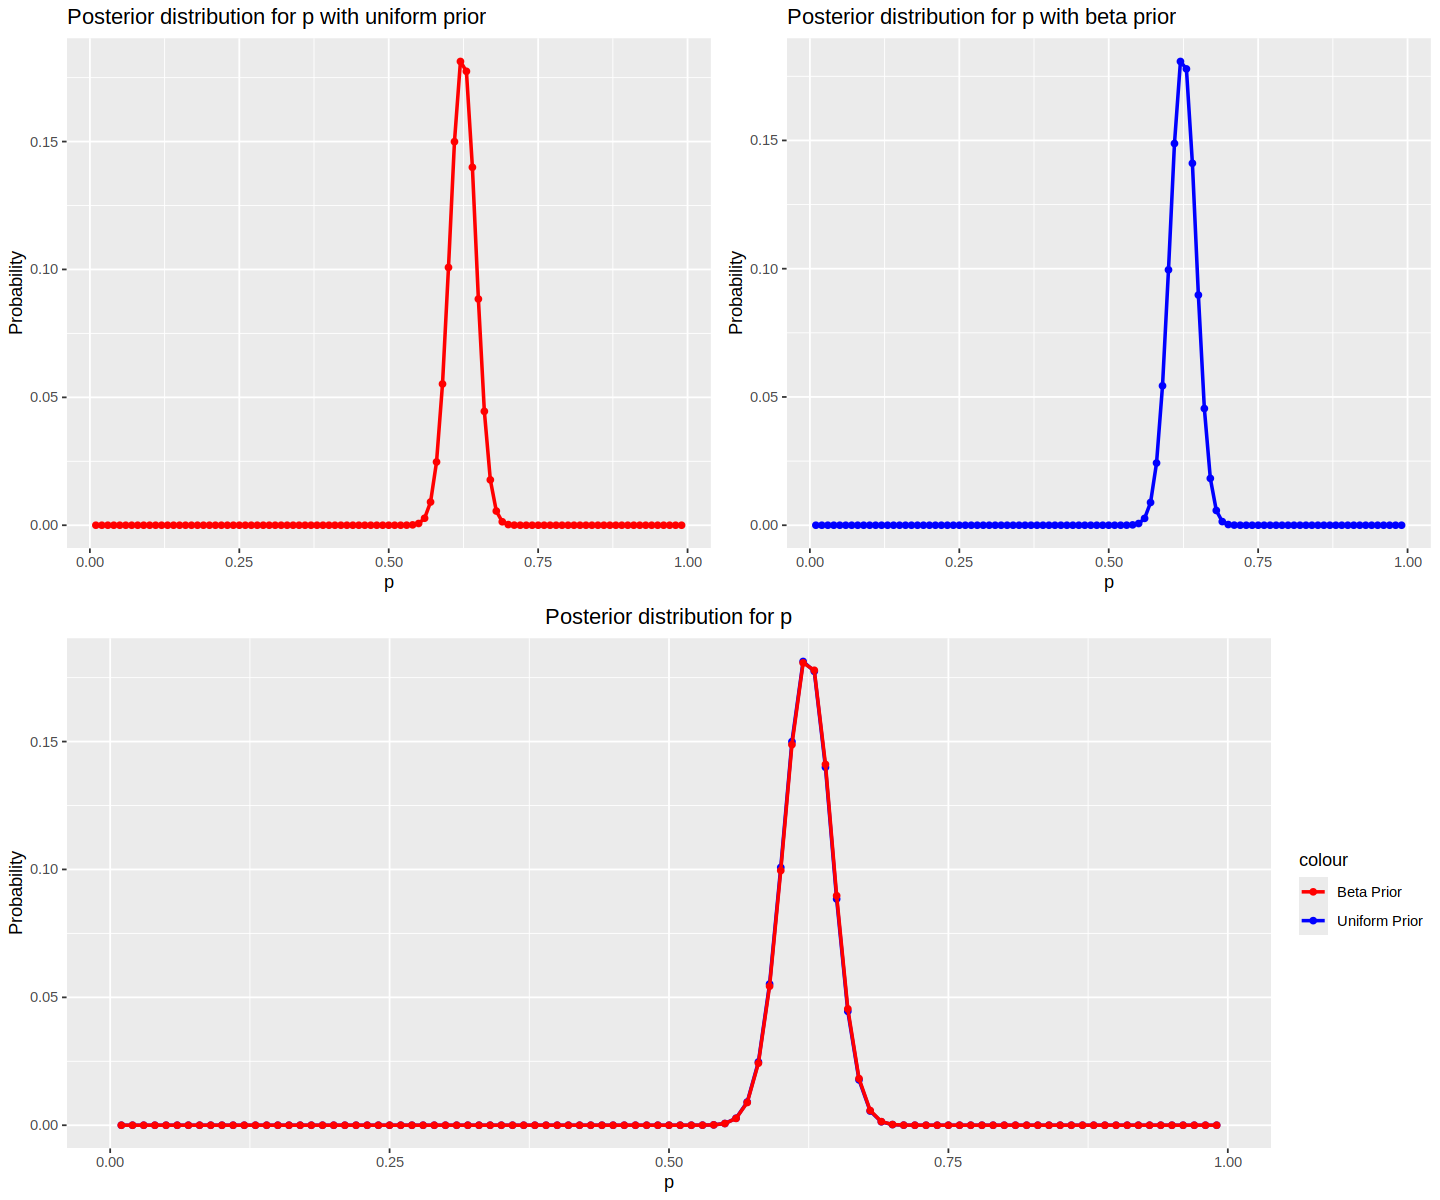

In [44]:
un_plot <- ggplot(data = data.frame(p, bern_un_values),
                  aes(x = p, y = bern_un_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for p with uniform prior",
       x = "p",
       y = "Probability")

beta_plot <- ggplot(data = data.frame(p, bern_beta_values),
                    aes(x = p, y = bern_beta_values)) +
  geom_point(color = "blue", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  labs(title = "Posterior distribution for p with beta prior",
       x = "p",
       y = "Probability")

mixed_plot <- ggplot(data = data.frame(p, bern_un_values, bern_beta_values),
                     aes(x = p)) +
  geom_point(aes(y = bern_un_values, color = "Uniform Prior"), size = 1.5) +
  geom_line(aes(y = bern_un_values, color = "Uniform Prior"), linewidth = 1) +
  geom_point(aes(y = bern_beta_values, color = "Beta Prior"), size = 1.5) +
  geom_line(aes(y = bern_beta_values, color = "Beta Prior"), linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability") +
  scale_color_manual(values = c("red", "blue"),
                     labels = c("Beta Prior", "Uniform Prior")) +
  theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 12, repr.plot.height = 10)
grid.arrange(un_plot, beta_plot, mixed_plot,
             layout_matrix = rbind(c(1, 2), c(3, 3)))

Taking into account that the same detector has been studied by researcher B, who has performed only $n = 10$ measurements and has obtained $r = 10$ signals: 

(c) Evaluate the mean, the variance and the posterior distribution using a uniform prior with the results of researcher B.

Mean with Uniform prior for researcher B: 0.9119989 
Variance with Uniform prior for researcher B: 0.006166099 


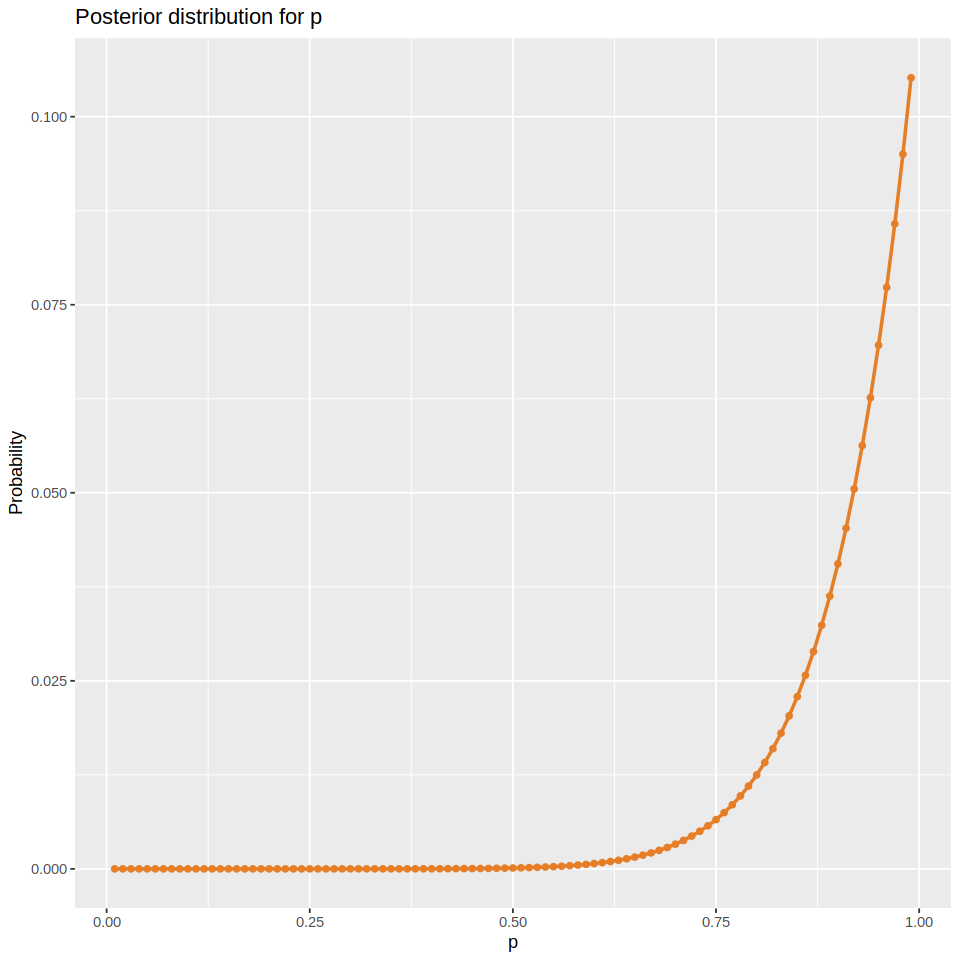

In [45]:
n_b <- 10
r_b <- 10

bern_un_values_b <- post_un_bern(r_b, n_b, c(min(p), max(p)), p)

cat("Mean with Uniform prior for researcher B:", weighted.mean(p, bern_un_values_b), "\n") # nolinter
cat("Variance with Uniform prior for researcher B:", weighted.var(p, bern_un_values_b), "\n") # nolinter

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(p, bern_un_values_b),
       aes(x = p, y = bern_un_values_b)) +
  geom_point(color = "#e67e28", size = 1.5) +
  geom_line(color = "#e67e28", linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability")

(d) Repeat the computation of points (a) and (b) with the data of researcher A using as a prior the posterior obtained from point (c).

Mean with Uniform prior for researcher B: 0.6308594 
Variance with Uniform prior for researcher B: 0.0005231835 


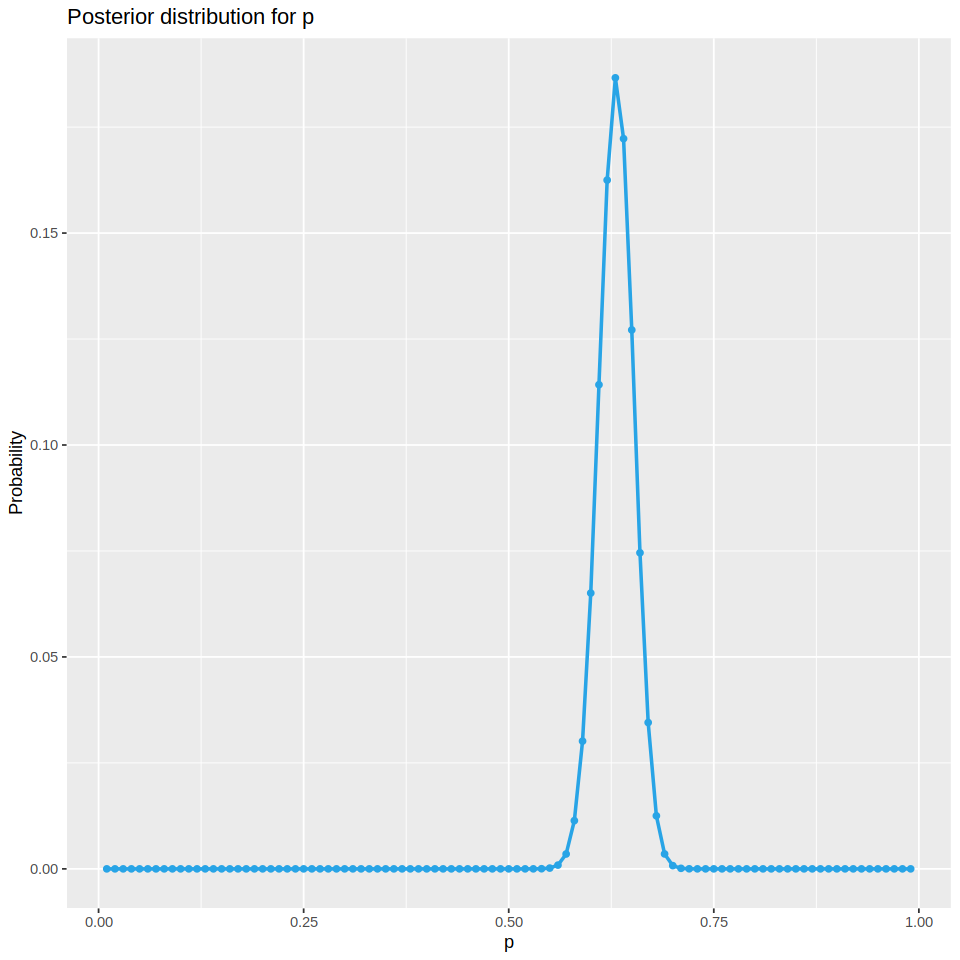

In [46]:
post_bern_b <- function(r, n, prior_values, p) {
  normalization <- sum(prior_values * dbinom(r, n, p))
  return(prior_values * dbinom(r, n, p) / normalization)
}

post_bern_values_b <- post_bern_b(r, n, bern_un_values_b, p)

cat("Mean with Uniform prior for researcher B:", weighted.mean(p, post_bern_values_b), "\n") # nolinter
cat("Variance with Uniform prior for researcher B:", weighted.var(p, post_bern_values_b), "\n") # nolinter

ggplot(data = data.frame(p, post_bern_values_b),
       aes(x = p, y = post_bern_values_b)) +
  geom_point(color = "#28a4e6", size = 1.5) +
  geom_line(color = "#28a4e6", linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability")

(e) [Optional] Compute 95% credible interval using the posterior of the previous point (d)

In [47]:
# USING c_int FUNCTION PREVIOUSLY DEFINED

bern_c_int <- c_int(post_bern_values_b, 0.95, p)

cat("95% Credibility Interval: (", bern_c_int[1], ",", bern_c_int[2], ")\n") # nolinter

95% Credibility Interval: ( 0.6 , 0.68 )


# Exercise 3 - Bayesian Inference for Binomial model

A coin is flipped $n = 30$ times with the following outcomes: T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H, H, H

(a) Assuming a flat prior, and a beta prior, plot the likelihood, prior and posterior distributions for the data set.

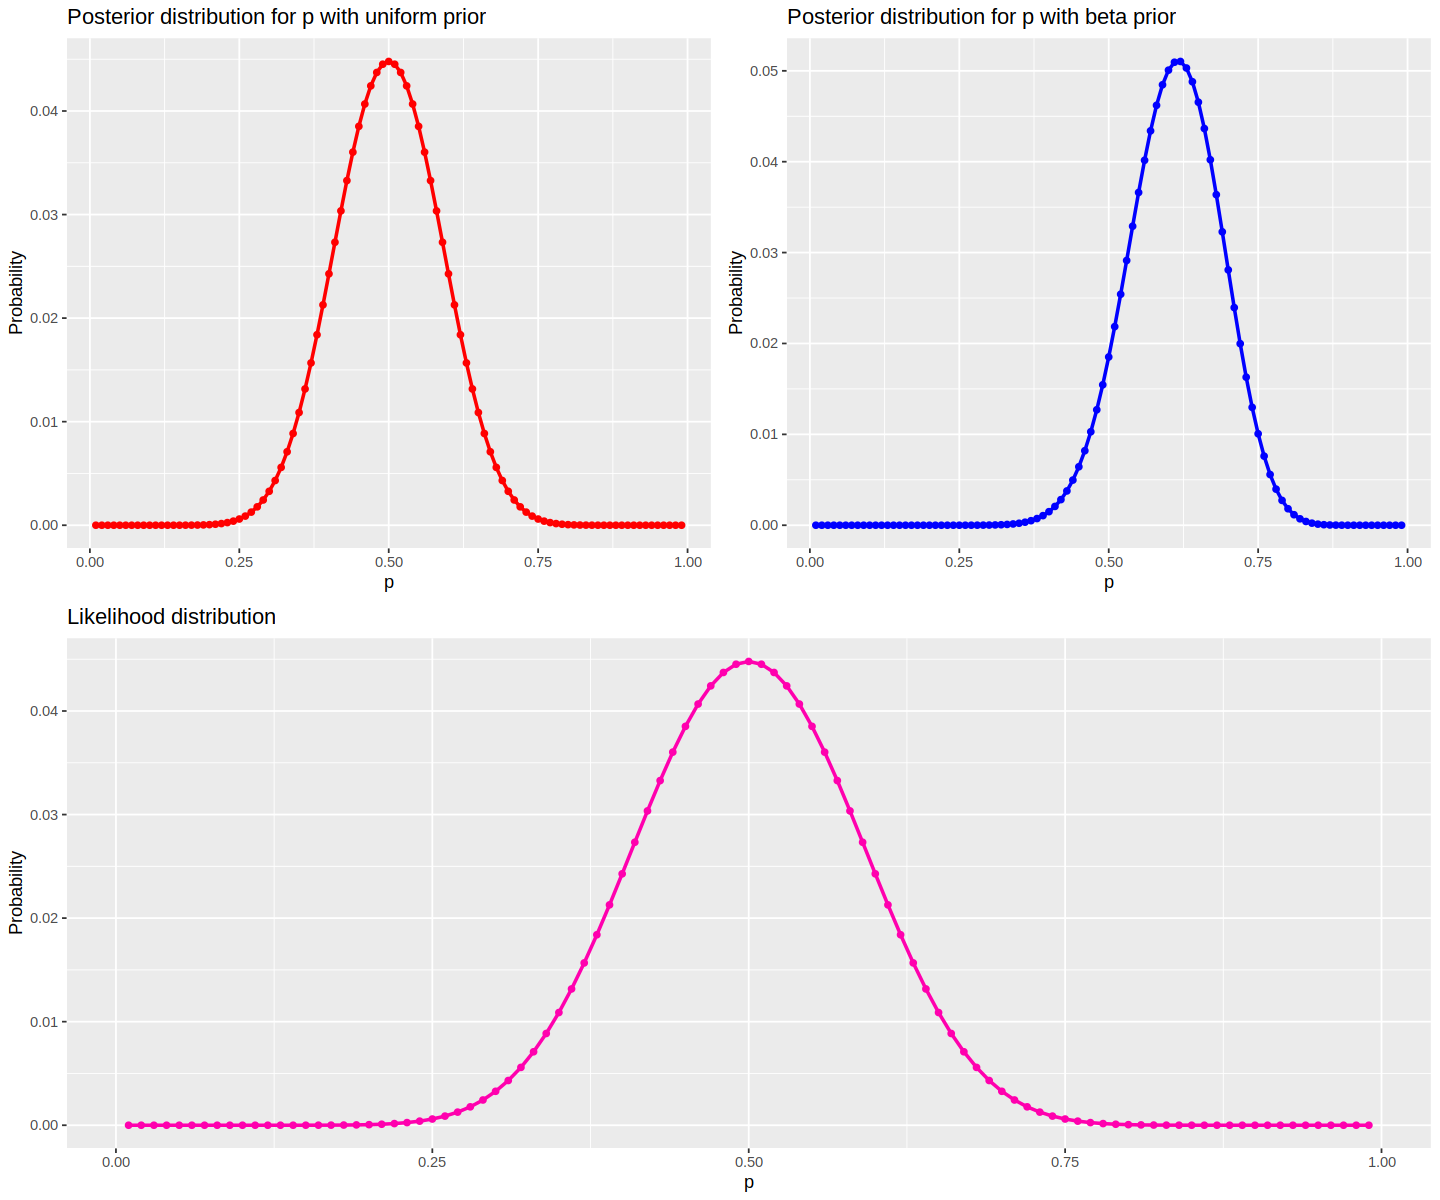

In [69]:
data <- c(1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
          0, 0, 1, 0, 1, 0, 1, 0, 0, 0)

n_coin <- length(data)
r_coin <- sum(data)
a <- 9
b <- 1 / 3

p <- seq(0.01, 1 - 0.01, 0.01)

likelihood <- function(n, r, p) {
  binomial_likelihood <- dbinom(r_coin, n_coin, p)

  return(binomial_likelihood / sum(binomial_likelihood))
}

likelihood_val <- likelihood(n, r, p)
coin_un_val <- post_un_bern(r, n, c(min(p), max(p)), p)
coin_beta_val <- post_beta_bern(r, n, c(a, b), p)

coin_un_plot <- ggplot(data = data.frame(p, coin_un_val),
                       aes(x = p, y = coin_un_val)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for p with uniform prior",
       x = "p",
       y = "Probability")

coin_beta_plot <- ggplot(data = data.frame(p, coin_beta_val),
                         aes(x = p, y = coin_beta_val)) +
  geom_point(color = "blue", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  labs(title = "Posterior distribution for p with beta prior",
       x = "p",
       y = "Probability")

likelihood_plot <- ggplot(data = data.frame(p, likelihood_val),
                          aes(x = p, y = likelihood_val)) +
  geom_point(color = "#ff00ae", size = 1.5) +
  geom_line(color = "#ff00ae", linewidth = 1) +
  labs(title = "Likelihood distribution",
       x = "p",
       y = "Probability")

options(repr.plot.width = 12, repr.plot.height = 10)
grid.arrange(coin_un_plot, coin_beta_plot, likelihood_plot,
             layout_matrix = rbind(c(1, 2), c(3, 3)))

(b) Evaluate the most probable value for the coin probability p and, integrating the posterior probability distribution, give an estimate for a 95% credibility interval.

(c) Repeat the same analysis assuming a sequential analysis of the data. Show how the most probable value and the credibility interval change as a function of the number of coin tosses (i.e. from 1 to 30).

(d) Do you get a different result, by analysing the data sequentially with respect to a one-step analysis (i.e. considering all the data as a whole)?